# Laboratoire 2 : Arbre de désision, Bayes naïf et KNN
#### Département du génie logiciel et des technologies de l’information

| Étudiants             |                                                         |
|-----------------------|---------------------------------------------------------|
| Jean-Philippe Decoste |  DECJ19059105                                           |
| Ahmad Al-Taher        |   ALTA22109307                                          |
| Cours                 | GTI770 - Systèmes intelligents et apprentissage machine |
| Session               | Automne 2018                                            |
| Groupe                | 2                                                       |
| Numéro du laboratoire | 02                                                      |
| Professeur            | Hervé Lombaert                                          |
| Chargé de laboratoire | Pierre-Luc Delisle                                      |
| Date                  | 30 oct 2018                                             |

### Classes et librairies utilisées

In [3]:
import csv
import math
import os

import graphviz
import matplotlib.pyplot as plt
import numpy as np
from image import Image as imageObj
from imageV2 import Image as imageFeat
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from spam import Spam
import utilities
from tabulate import tabulate

## Paramètres de l'application

In [4]:
#LAB01
IMAGE_CSV_NAME = r"data\csv\galaxy\galaxy_label_data_set.csv"
IMAGETEST_CSV_NAME = r"data\csv\galaxy\galaxy_label_data_set_test.csv"

#Galaxy features
EXTRATED_GALAXY_PRIMITIVE = r"data\csv\eq07_pExtraction.csv"
MERGED_GALAXY_PRIMITIVE = r"data\csv\eq07_pMerged.csv"
ALL_GALAXY_PRIMITIVE = r"data\csv\galaxy\galaxy_feature_vectors.csv"

#Spam features
ALL_SPAM_PRIMITIVE = r"data\csv\spam\spam.csv"

#Algo params
TREE_DEPTH = [None, 3, 5, 10]
EXTRACT_TREE_PDF = False
N_NEIGHBORS = [3, 5, 10]
WEIGHTS = ['uniform', 'distance']

#General config
PRIMITIVE_SCANNING = True
DOMERGE = False
PRINT_GRAPH = True

### Arbre de décision

In [12]:
def decisionTree():
    """
    This method is used to build the decision tree and how the graph associated with it.
    fit(x,y) takes two arrays:
    X, sparse or dense, of size [n_samples, n_features] holding the training samples, and an array
            ex: [[0, 0], [1, 1]]
    Y of integer values, size [n_samples], holding the class labels
            ex : [0, 1]

    Since out Y array is not numerical we are using preprocessing from klearn to transform them
    Args:
        data: the array containing all the features. It will be used as the X
        labels: the array containing all the labels. It will be used as the Y
    """
    print("1.Training with Holdout\n")
    dTreePerf = [['Depth', 'Accuracy', 'Precision', 'F1']]
    params = dict(max_depth=TREE_DEPTH)
    holdoutValidation = ShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
    grid = GridSearchCV(DecisionTreeClassifier(), param_grid=params, cv=holdoutValidation, n_jobs=-1, iid=True, scoring={'accuracy', 'precision', 'f1'}, refit='accuracy')
   
    #Fit data to Decision Tree algo
    grid.fit(features, answers)

    #Loop through results
    for i in range(0, 4):
        dTreePerf.append([grid.cv_results_['params'][i]['max_depth'],
                          "{0:.2f}".format(grid.cv_results_['mean_test_accuracy'][i]*100),
                          "{0:.2f}".format(grid.cv_results_['mean_test_precision'][i]*100),
                          "{0:.2f}".format(grid.cv_results_['mean_test_f1'][i]*100)])
        
    utilities.traceGraph([0, 2, 4, 6, 8, 10],TREE_DEPTH,'Profondeur',[0, .2,.4,.6,.8,1],TREE_DEPTH,'Pourcentage','k','accuracy', "accuracy/K")

    print(tabulate(dTreePerf, headers="firstrow"))
    print("\nThe best is depth = %s" %(grid.best_params_['max_depth']))
    
    print("\n2.Training best params with 5-fold cross-validation\n")
    dTreePerf = [['Depth', 'Accuracy', 'Precision', 'F1']]
    params = dict(max_depth=[grid.best_params_['max_depth']])
    bestGrid = GridSearchCV(DecisionTreeClassifier(), param_grid=params, cv=5, n_jobs=-1, iid=True, scoring={'accuracy', 'precision', 'f1'}, refit='accuracy')
    
    #Fit data to Decision Tree algo
    bestGrid.fit(features, answers)
    
    dTreePerf.append([bestGrid.cv_results_['params'][0]['max_depth'],
                      "{0:.2f}".format(bestGrid.cv_results_['mean_test_accuracy'][0]*100),
                      "{0:.2f}".format(bestGrid.cv_results_['mean_test_precision'][0]*100),
                      "{0:.2f}".format(bestGrid.cv_results_['mean_test_f1'][0]*100)])
    
    print(tabulate(dTreePerf, headers="firstrow"))
    print("-> Done\n\n")

### KNN

In [6]:
def knn():
    print("1.Training with Holdout\n")
    knnPerf = [['Weights', 'K', 'Accuracy', 'Precision', 'F1']]
    params = dict(n_neighbors=N_NEIGHBORS, weights=WEIGHTS, algorithm=['auto'])
    holdoutValidation = ShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
    grid = GridSearchCV(KNeighborsClassifier(), param_grid=params, cv=holdoutValidation, n_jobs=-1, iid=True, scoring={'accuracy', 'precision', 'f1'}, refit='accuracy')

    #Fit data to knn algo
    grid.fit(features, answers)

    #Loop through results
    for i in range(0, 6):
        knnPerf.append([grid.cv_results_['params'][i]['weights'],
                        grid.cv_results_['params'][i]['n_neighbors'],
                        "{0:.2f}".format(grid.cv_results_['mean_test_accuracy'][i]*100),
                        "{0:.2f}".format(grid.cv_results_['mean_test_precision'][i]*100),
                        "{0:.2f}".format(grid.cv_results_['mean_test_f1'][i]*100)])

    print(tabulate(knnPerf, headers="firstrow"))
    print("\nThe best is KNN %s With K = %s" %(grid.best_params_['weights'], grid.best_params_['n_neighbors']))
    
    print("\n2.Training best params with 5-fold cross-validation\n")
    knnPerf = [['Weights', 'K', 'Accuracy', 'Precision', 'F1']]
    params = dict(n_neighbors=[grid.best_params_['n_neighbors']], weights=[grid.best_params_['weights']], algorithm=['auto'])
    bestGrid = GridSearchCV(KNeighborsClassifier(), param_grid=params, cv=5, n_jobs=-1, iid=True, scoring={'accuracy', 'precision', 'f1'}, refit='accuracy')
    
    #Fit data to knn algo
    bestGrid.fit(features, answers)
    
    knnPerf.append([bestGrid.cv_results_['params'][0]['weights'],
                    bestGrid.cv_results_['params'][0]['n_neighbors'],
                    "{0:.2f}".format(bestGrid.cv_results_['mean_test_accuracy'][0]*100),
                    "{0:.2f}".format(bestGrid.cv_results_['mean_test_precision'][0]*100),
                    "{0:.2f}".format(bestGrid.cv_results_['mean_test_f1'][0]*100)])
    
    print(tabulate(knnPerf, headers="firstrow"))
    print("-> Done\n\n")

### Bayes (MultinomialMB)

In [7]:
def bayes():
    print("1.Training with Holdout\n")
    bayesPerf = [['Data type', 'Accuracy', 'Precision', 'F1']]
    params = dict()
    holdoutValidation = ShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
    grid = GridSearchCV(MultinomialNB(), param_grid=params, cv=holdoutValidation, n_jobs=-1, iid=True, scoring={'accuracy', 'precision', 'f1'}, refit='accuracy')

    #Scale the data between 0 and 1
    scaler = preprocessing.MinMaxScaler()
    scaler.fit(features)
    xNormalized = scaler.transform(features)

    #Fit normalized data to Bayes algo
    grid.fit(xNormalized, answers)
    bayesPerf.append(['Normalized',
                      "{0:.2f}".format(float(grid.cv_results_['mean_test_accuracy'])*100),
                      "{0:.2f}".format(float(grid.cv_results_['mean_test_precision'])*100),
                      "{0:.2f}".format(float(grid.cv_results_['mean_test_f1'])*100)])
    normalizedResult = float(grid.cv_results_['mean_test_accuracy'])
    
    #Discretize normalized data
    est = preprocessing.KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')
    est.fit(features)
    xKBinsDiscretizer = est.transform(features)

    #Fit discretize data to bayes algorithm
    grid.fit(xKBinsDiscretizer, answers)
    bayesPerf.append(['Discretized',
                        "{0:.2f}".format(float(grid.cv_results_['mean_test_accuracy'])*100),
                        "{0:.2f}".format(float(grid.cv_results_['mean_test_precision'])*100),
                        "{0:.2f}".format(float(grid.cv_results_['mean_test_f1'])*100)])
    discretizedResult = float(grid.cv_results_['mean_test_accuracy'])
    
    print(tabulate(bayesPerf, headers="firstrow"))
    
    print("\n2.Training best params with 5-fold cross-validation\n")
    bayesPerf = [['Data type', 'Accuracy', 'Precision', 'F1']]
    params = dict()
    bestGrid = GridSearchCV(MultinomialNB(), param_grid=params, cv=5, n_jobs=-1, iid=True, scoring={'accuracy', 'precision', 'f1'}, refit='accuracy')
    
    #Fit data to Bayes algo
    if normalizedResult > discretizedResult:
        bestGrid.fit(xNormalized, answers)
    else:
        bestGrid.fit(xKBinsDiscretizer, answers)
    
    bayesPerf.append(['Discretized',
                        "{0:.2f}".format(float(bestGrid.cv_results_['mean_test_accuracy'])*100),
                        "{0:.2f}".format(float(bestGrid.cv_results_['mean_test_precision'])*100),
                        "{0:.2f}".format(float(bestGrid.cv_results_['mean_test_f1'])*100)])
    
    print(tabulate(bayesPerf, headers="firstrow"))
    print("-> Done\n\n")

In [8]:
def lab2_prepareDataset(datasetName, dataset):
    print("PREPARING DATASETS")
    allData_length = len(list(csv.reader(open(dataset))))
    progress = 0
    datas = []

    print("Reading " + datasetName + " features:")
    utilities.printProgressBar(0, allData_length, prefix='Progress:', suffix='Complete', length=50)
    with open(dataset, 'r') as theFile:
        primitives = csv.reader(theFile, delimiter=',', quotechar='|')

        for row in primitives:
            progress += 1
            utilities.printProgressBar(progress+1, allData_length, prefix='Progress', suffix='Complete', length=50)

            values = [float(i) for i in row]
            if datasetName == "Galaxy":
                datas.append(imageFeat(values))
            elif datasetName == "Spam":
                datas.append(Spam(values))
    print("\n-> Done\n")

    #3. Split dataset using model_selection
    for data in np.array(datas):
        features.append(data.features)
        answers.append(data.answer)

PREPARING DATASETS
Reading Galaxy features:
Progress |**************************************************| 100.0% Complete
-> Done

ALGORITHMS

Decision Tree:
1.Training with Holdout



ValueError: x and y must be the same size

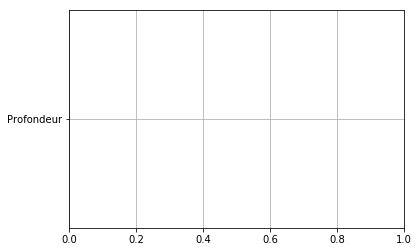

In [13]:
#0. Generate new feature files for Galaxy (only run once)
#utilities.lab1_extractFeatures()

#1.A Read Galaxy features (name of file, path, n_split, test size, random state)
features = []
answers = []
if os.path.isfile(MERGED_GALAXY_PRIMITIVE):
    lab2_prepareDataset("Galaxy", MERGED_GALAXY_PRIMITIVE)
else:
    lab2_prepareDataset("Galaxy", ALL_GALAXY_PRIMITIVE)

#2.A Execute Algorithm
print("ALGORITHMS")
#2.1. DECISION TREE
print("\nDecision Tree:")
decisionTree()
#2.2. KNN
print("KNN:")
knn()
#2.3. BAYES
print("\nBayes MultinomialNB")
bayes()




#3.B Read Spams features (name of file, path, n_split, test size, random state)
features = []
answers = []
lab2_prepareDataset("Spam", ALL_SPAM_PRIMITIVE)

#4.B Execute Algorithm
print("ALGORITHMS")
#4.1. DECISION TREE
print("\nDecision Tree:")
decisionTree()
#4.2. KNN
print("KNN:")
knn()
#4.3. BAYES
print("\nBayes MultinomialNB")
bayes()


## Introduction

*to delete
résultat des algo sans rajouté de nos premitive
KNN uniform has a score of 0.68 with k=3 
KNN distance has a score of 0.69 with k=3 
KNN uniform has a score of 0.64 with k=5 
KNN distance has a score of 0.65 with k=5 
KNN uniform has a score of 0.69 with k=10 
KNN distance has a score of 0.67 with k=10 
The best parameters are {'algorithm': 'auto', 'n_neighbors': 3, 'weights': 'distance'} with a score of 0.69
MultinomialNB with normalized values best score is 0.89
MultinomialNB with discretized values best score is 0.77
Working with the images
KNN uniform has a score of 0.61 with k=3 
KNN distance has a score of 0.59 with k=3 
KNN uniform has a score of 0.62 with k=5 
KNN distance has a score of 0.60 with k=5 
KNN uniform has a score of 0.62 with k=10 
KNN distance has a score of 0.63 with k=10 
The best parameters are {'algorithm': 'auto', 'n_neighbors': 10, 'weights': 'distance'} with a score of 0.63
MultinomialNB with normalized values best score is 0.71
MultinomialNB with discretized values best score is 0.71

## Analyse

## Question 1
### Méthode de création des ensembles de données

## Question 1
### Détails des ensembles produits

## Question 2
### Approche de validation proposée et justification

## Question 3
### Matrice des expérimentations

## Question 3
### Étude des hyperparamètres et des modèles

## Question 4
### Impact de la taille des ensembles de données sur la performance de classification

## Question 5
### Impact du bruit dans les ensembles de données sur la performance de classification

## Question 6
### Discussion sur la nature des données

## Question 7
### Recommandations

## Question 8
### Améliorations possibles

## Conclusion

## Bibliographie